In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install tqdm

!pip install evaluate
!pip install bert_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import torch
from transformers import BertForSequenceClassification, BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn as nn
from tqdm import tqdm
from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import DebertaConfig, DebertaTokenizer, DebertaForSequenceClassification

from evaluate import load
bertscore = load("bertscore")
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!ls "/content/drive/My Drive/snlp-project/data"

datasetSentences.txt  dictionary.txt		README.txt	      SOStr.txt
datasetSplit.txt      original_rt_snippets.txt	sentiment_labels.txt  STree.txt


In [ ]:
dictionary = pd.read_csv('/content/drive/My Drive/snlp-project/data/dictionary.txt', sep='|')
sentiment_labels = pd.read_csv('/content/drive/My Drive/snlp-project/data/sentiment_labels.txt', sep='|')
dataset_sentences = pd.read_csv('/content/drive/My Drive/snlp-project/data/datasetSentences.txt', sep='\t')
dataset_split = pd.read_csv('/content/drive/My Drive/snlp-project/data/datasetSplit.txt', sep=',')

In [ ]:
print(dataset_split.head())
print(dataset_sentences.head())
print(sentiment_labels.head())
dictionary = dictionary.rename(columns={'0':'phrase ids'})
print(dictionary.head())
print(len(dataset_split))

   sentence_index  splitset_label
0               1               1
1               2               1
2               3               2
3               4               2
4               5               2
   sentence_index                                           sentence
0               1  The Rock is destined to be the 21st Century 's...
1               2  The gorgeously elaborate continuation of `` Th...
2               3                     Effective but too-tepid biopic
3               4  If you sometimes like to go to the movies to h...
4               5  Emerges as something rare , an issue movie tha...
   phrase ids  sentiment values
0           0           0.50000
1           1           0.50000
2           2           0.44444
3           3           0.50000
4           4           0.42708
               !  phrase ids
0            ! '       22935
1           ! ''       18235
2         ! Alas      179257
3    ! Brilliant       22936
4  ! Brilliant !       40532
11855


In [ ]:
merged = dataset_split.merge(dataset_sentences, on='sentence_index')
merged = merged.merge(dictionary, left_on='sentence', right_on='!')
merged = merged.merge(sentiment_labels, on='phrase ids')

merged = merged.loc[:, ['sentence', 'sentiment values', 'splitset_label']]

trainset = merged.loc[merged['splitset_label'] == 1, ['sentence', 'sentiment values']]
testset = merged.loc[merged['splitset_label'] == 2, ['sentence', 'sentiment values']]
devset = merged.loc[merged['splitset_label'] == 3, ['sentence', 'sentiment values']]

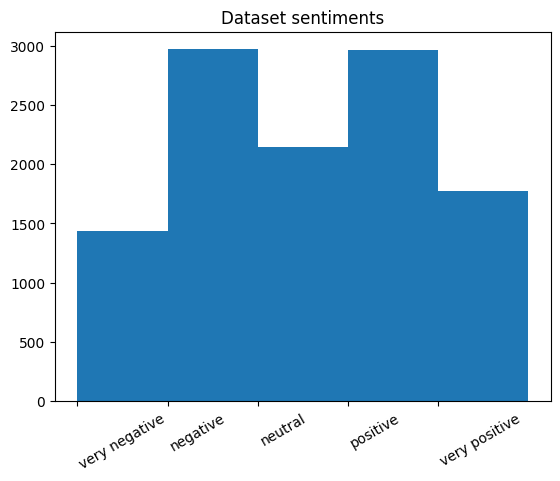

In [ ]:
plt.hist(merged['sentiment values'], bins = 5)
plt.xticks(np.arange(0,1,step=0.2) ,['very negative','negative','neutral','positive','very positive'],rotation=30, ha="left")
plt.title('Dataset sentiments')
plt.show()

In [ ]:
sentences = merged['sentence']
s_sentences = ''
for word in sentences:
    s_sentences += word

words = s_sentences.split()

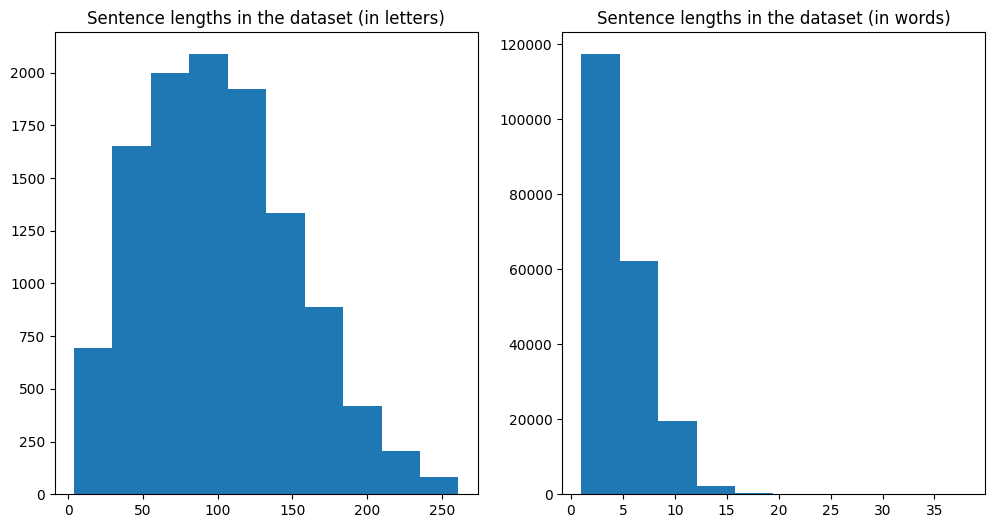

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist([len(x) for x in merged['sentence']])
ax[1].hist([len(x) for x in words])
ax[0].set_title('Sentence lengths in the dataset (in letters)')
ax[1].set_title('Sentence lengths in the dataset (in words)')
plt.show()

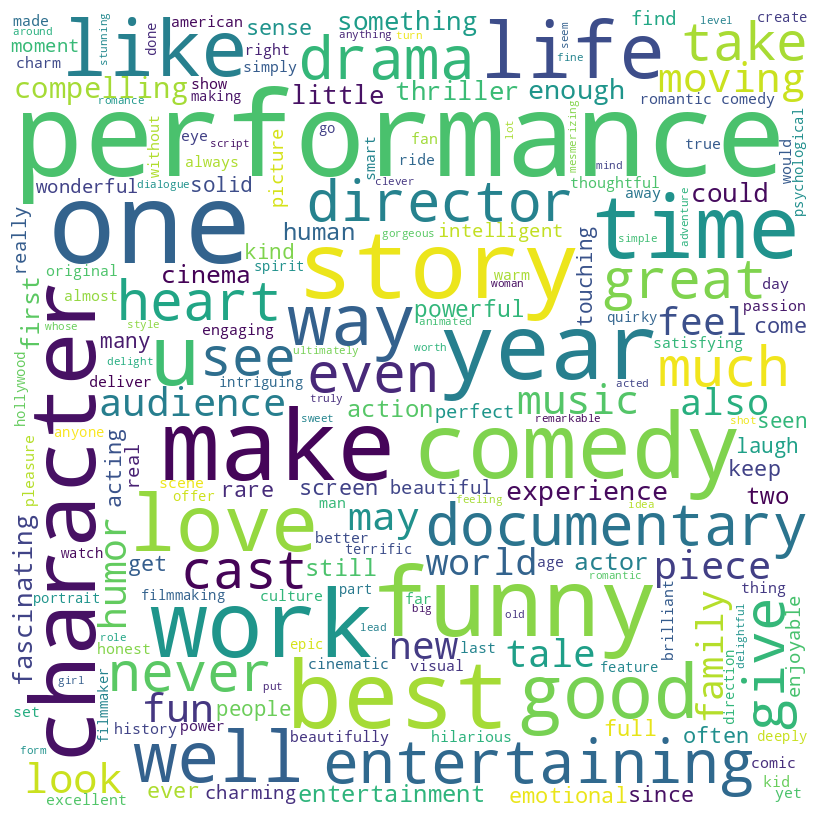

In [ ]:
vpos_reviews = merged.loc[merged['sentiment values'] > 0.8]
vneg_reviews = merged.loc[merged['sentiment values'] < 0.2]
pos_reviews = merged.loc[(merged['sentiment values'] > 0.6) & (merged['sentiment values'] <= 0.8)]
neu_reviews = merged.loc[(merged['sentiment values'] > 0.4) & (merged['sentiment values'] <= 0.6)]
neg_reviews = merged.loc[(merged['sentiment values'] > 0.2) & (merged['sentiment values'] <= 0.4)]

vpos_contents = vpos_reviews['sentence'] # changing for vpos,neu,neg,vneg
contents = ""
for i in vpos_contents:
    contents += i

# creating a wordcloud from the contents
tokens = word_tokenize(contents)
lowercased = [t.lower() for t in tokens]
alph = [t for t in lowercased if t.isalpha()]
words = stopwords.words("english")
words.append('movie')
words.append('film')
stopwords_remo = [t for t in alph if t not in words]
lemmatizer = WordNetLemmatizer()
lem_tokens = [lemmatizer.lemmatize(t) for t in stopwords_remo]
bag_words = Counter(lem_tokens)

lemStr = ' '.join(map(str, lem_tokens))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = words,
                min_font_size = 10).generate(lemStr)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Okay so I did some initial data analysis and created separate datasets for the train,test and dev splits! -Iida

Testing out sentiment analysis with bert - Daniel

In [ ]:
def create_encodings(trainset, testset, tokenizer):
  encoded_train = tokenizer.batch_encode_plus(trainset.sentence.values,
                                            add_special_tokens = True,
                                            return_attention_mask = True,
                                            pad_to_max_length = True,
                                              truncation=True,
                                            max_length = max([len(x) for x in dataset_sentences['sentence']]),
                                            return_tensors = 'pt')


  encoded_test = tokenizer.batch_encode_plus(testset.sentence.values,
                                            add_special_tokens = True,
                                            return_attention_mask = True,
                                            pad_to_max_length = True,
                                              truncation=True,
                                            max_length = max([len(x) for x in dataset_sentences['sentence']]),
                                            return_tensors = 'pt')
  return encoded_train, encoded_test

In [ ]:
def create_dataloader(input_ids, attn_masks, labels, batch_size =40):
  dataset = TensorDataset(input_ids_train,
                                attn_masks_train,
                                labels_train)

  return DataLoader(
      dataset,
      sampler=RandomSampler(dataset),
      batch_size=batch_size
  )



In [ ]:
def map_values(values):
  value_list = []
  for value in values:
    assert 0 <= value <= 1, f"Input value should be between 0 and 1: {values}"

    categories = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
    num_categories = len(categories)

    index = int(value * num_categories)

    if index == num_categories:
        index -= 1

    value_list.append(categories[index])
  return value_list

print(map_values([0.11, 0.31, 0.51, 0.71, 0.91]))

['very negative', 'negative', 'neutral', 'positive', 'very positive']


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def create_confusion_matrix(predictions, references):

  cm = confusion_matrix(references, predictions)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive'])
  cm_display.plot()
  plt.show()

  return cm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def tune_model(model, dataloader, optimizer, epochs=10):
  # Set the device to GPU if available
  model.to(device)
  prev_loss = 0
  tolerance = 1
  count = 0

  # Training loop
  for epoch in range(epochs):
      print(f'Epoch {epoch + 1}/{epochs}')
      print('-' * 30)

      # Set the model to training mode
      model.train()

      # Initialize the total loss for the epoch
      total_loss = 0

      # Iterate over the training data
      for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
          # Move the input tensors to the GPU if available
          input_ids = batch[0].to(device)
          attention_mask = batch[1].to(device)
          labels = batch[2].to(device, dtype=torch.float32)

          # Clear any previously calculated gradients
          model.zero_grad()

          # Perform a forward pass through the model
          outputs = model(input_ids, attention_mask=attention_mask).logits.squeeze()

          # Calculate the mean squared error loss
          mse_loss = nn.MSELoss()
          loss = mse_loss(outputs, labels)

          # Backpropagate the gradients
          loss.backward()

          # Update the model parameters
          optimizer.step()

          # Update the total loss for the epoch
          total_loss += loss.item()

      # Calculate the average loss for the epoch
      avg_train_loss = total_loss / len(dataloader_train)
      print(f'Average training loss: {avg_train_loss}')
      if(avg_train_loss > prev_loss):
        count += 1
        if(count> 1):
          print("Early stopping")
          return model, avg_train_loss
      prev_loss = avg_train_loss

  return model, avg_train_loss



In [ ]:
def evaluate_model(model, dataloader):
# Set the model to evaluation mode
  #bertscore = load("bertscore")

  model.eval()

  # Initialize the total loss and the list to store true and predicted labels
  total_loss = 0
  true_labels = []
  predicted_labels = []
  mse_loss = nn.MSELoss()

  # Testing loop (no gradients need to be calculated)
  with torch.no_grad():
      for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
          # Move the input tensors to the GPU if available
          input_ids = batch[0].to(device)
          attention_mask = batch[1].to(device)
          labels = batch[2].to(device)

          # Perform a forward pass through the model
          outputs = model(input_ids, attention_mask=attention_mask).logits.squeeze()

          # Calculate the mean squared error loss

          loss = mse_loss(outputs, labels)

          # Update the total loss for the test dataset
          total_loss += loss.item()

          # Store the true and predicted labels
          true_labels.extend(labels.detach().cpu().numpy())
          predicted_labels.extend(outputs.detach().cpu().numpy())

  # Calculate the average loss for the test dataset
  avg_test_loss = total_loss / len(dataloader_test)
  print(f'Average test loss: {avg_test_loss}')
  predicted_labels_str = map_values(predicted_labels)
  true_labels_str = map_values(true_labels)

  le = LabelEncoder()

  true_labels_num = le.fit_transform(true_labels_str)
  predicted_labels_num = le.transform(predicted_labels_str)

  create_confusion_matrix(predicted_labels_str, true_labels_str)
  # Calculate the F1 score
  f1 = f1_score(true_labels_num, predicted_labels_num, average='weighted')

  print(f"F1 score: {f1}")


  return avg_test_loss, f1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Average test loss: 0.10024968294934117


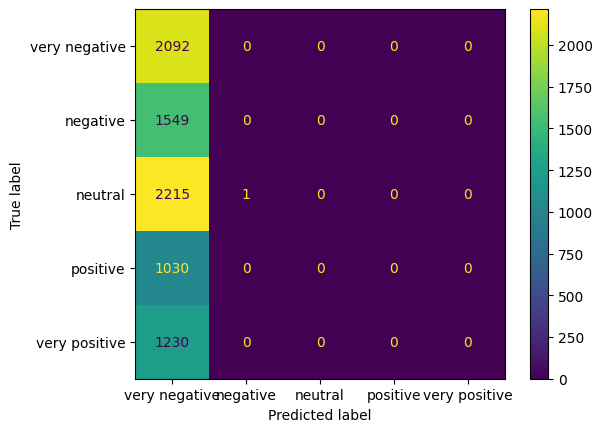

F1 score: 0.10563726503028012
Final mse on test set before tuning: 0.10024968294934117
Epoch 1/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.034385857360409985
Epoch 2/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.01979952626701059
Epoch 3/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.014654316615973934
Epoch 4/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.011438688586736695
Epoch 5/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.009164427542425876
Epoch 6/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.0077983844518349525
Epoch 7/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.006619168664535205
Epoch 8/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.005759926588536043
Epoch 9/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.005026506071937789
Epoch 10/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.004471792443770126
Final mse on training set: 0.004471792443770126


100%|██████████| 203/203 [02:22<00:00,  1.43it/s]


Average test loss: 0.00291712672593002


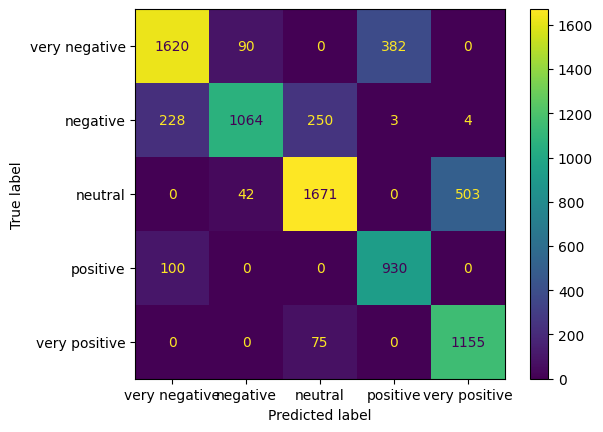

F1 score: 0.7929395865908176
Final mse on test set: (0.00291712672593002, 0.7929395865908176)


In [ ]:
#creating tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)
#initializing bert model
#config = BertConfig.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased',
                                      num_labels = 1,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )
config = model.config
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(config.hidden_size, 1),
    torch.nn.Sigmoid()
)

#initalizaing optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

#creating encodings
encoded_train, encoded_test = create_encodings(trainset, testset, tokenizer)

input_ids_train = encoded_train['input_ids']
attn_masks_train = encoded_train['attention_mask']
labels_train = torch.tensor(trainset['sentiment values'].values)

input_ids_test = encoded_test['input_ids']
attn_masks_test = encoded_test['attention_mask']
labels_test = torch.tensor(testset['sentiment values'].values)

#creating data loaders
dataloader_train = create_dataloader(input_ids_train, attn_masks_train, labels_train)
dataloader_test = create_dataloader(input_ids_test, attn_masks_test, labels_test)

model.to(device)
model.eval()
test_mse, test_f1 = evaluate_model(model, dataloader_test)
print(f"Final mse on test set before tuning: {test_mse}")

#training the model
model, mse = tune_model(model, dataloader_train, optimizer)

print(f"Final mse on training set: {mse}")

#evaluating model
test_mse, test_f1 = evaluate_model(model, dataloader_test)
print(f"Final mse on test set: {test_mse}")


In [ ]:
# Save the model weights and configuration
model.save_pretrained("my_trained_model")
# Delete the model and any other unnecessary variables
del model

# Clear GPU memory
torch.cuda.empty_cache()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Average test loss: 0.07547403131447826


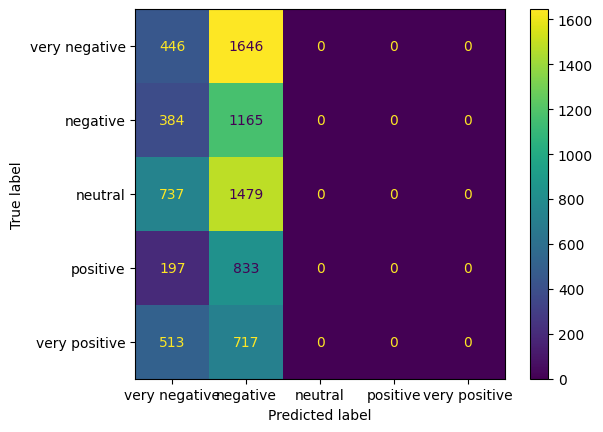

F1 score: 0.11279615919117626
Final mse on test set before tuning: 0.07547403131447826
Epoch 1/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.03825428396500097
Epoch 2/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.020283069672622705
Epoch 3/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.014166739865623671
Epoch 4/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.010872933655757035
Epoch 5/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.008524346270878327
Epoch 6/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.007113353263247263
Epoch 7/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.005838440354968527
Epoch 8/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.005241790771475199
Epoch 9/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.004395340595697167
Epoch 10/10
------------------------------


100%|██████████| 203/203 [06:09<00:00,  1.82s/it]


Average training loss: 0.004090392717797989
Final mse on training set: 0.004090392717797989


100%|██████████| 203/203 [02:22<00:00,  1.42it/s]


Average test loss: 0.0023791499058492824


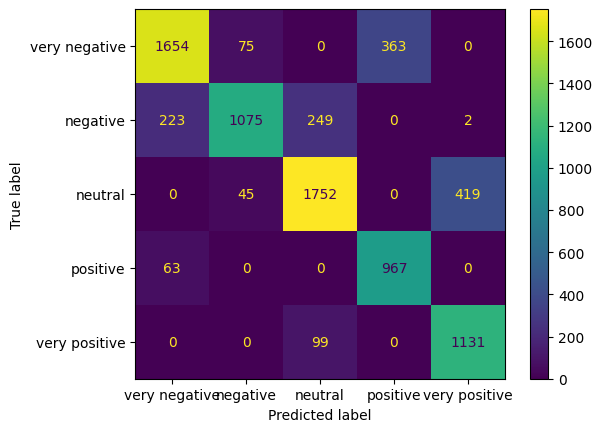

F1 score: 0.8098183258040578
Final mse on test set: 0.0023791499058492824


In [ ]:
#creating tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased',
                                         do_lower_case = True)
#initializing bert model
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-cased',
                                      num_labels = 1,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )
config = model.config
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(config.hidden_size, 1),
    torch.nn.Sigmoid()
)

#initalizaing optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

#creating encodings
encoded_train, encoded_test = create_encodings(trainset, testset, tokenizer)

input_ids_train = encoded_train['input_ids']
attn_masks_train = encoded_train['attention_mask']
labels_train = torch.tensor(trainset['sentiment values'].values)

input_ids_test = encoded_test['input_ids']
attn_masks_test = encoded_test['attention_mask']
labels_test = torch.tensor(testset['sentiment values'].values)

#creating data loaders
dataloader_train = create_dataloader(input_ids_train, attn_masks_train, labels_train)
dataloader_test = create_dataloader(input_ids_test, attn_masks_test, labels_test)

model.to(device)
model.eval()
test_mse, test_f1 = evaluate_model(model, dataloader_test)
print(f"Final mse on test set before tuning: {test_mse}")

#training the model
model, mse = tune_model(model, dataloader_train, optimizer)

print(f"Final mse on training set: {mse}")

#evaluating model
test_mse, test_f1 = evaluate_model(model, dataloader_test)
print(f"Final mse on test set: {test_mse}")


In [ ]:
# Save the model weights and configuration
model.save_pretrained("my_trained_model_cased")
# Delete the model and any other unnecessary variables
del model

# Clear GPU memory
torch.cuda.empty_cache()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Average test loss: 0.06330619990374686


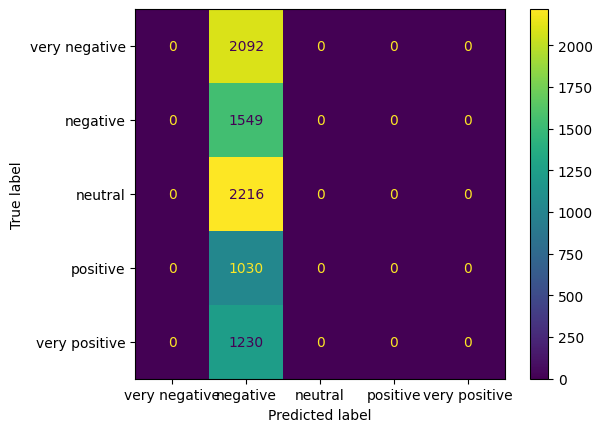

F1 score: 0.06116324157499895
Final mse on test set before tuning: 0.06330619990374686
Epoch 1/10
------------------------------


100%|██████████| 203/203 [03:02<00:00,  1.11it/s]


Average training loss: 0.03528334996364827
Epoch 2/10
------------------------------


100%|██████████| 203/203 [03:02<00:00,  1.11it/s]


Average training loss: 0.021629312291300943
Epoch 3/10
------------------------------


100%|██████████| 203/203 [03:02<00:00,  1.11it/s]


Average training loss: 0.01643184107714539
Epoch 4/10
------------------------------


100%|██████████| 203/203 [03:02<00:00,  1.11it/s]


Average training loss: 0.012881568518325026
Epoch 5/10
------------------------------


100%|██████████| 203/203 [03:02<00:00,  1.11it/s]


Average training loss: 0.010283735115081072
Epoch 6/10
------------------------------


100%|██████████| 203/203 [03:02<00:00,  1.11it/s]


Average training loss: 0.008584009625678285
Epoch 7/10
------------------------------


100%|██████████| 203/203 [03:02<00:00,  1.11it/s]


Average training loss: 0.007182215285381954
Epoch 8/10
------------------------------


100%|██████████| 203/203 [03:02<00:00,  1.11it/s]


Average training loss: 0.0064012433856432075
Epoch 9/10
------------------------------


100%|██████████| 203/203 [03:02<00:00,  1.11it/s]


Average training loss: 0.005462647916914281
Epoch 10/10
------------------------------


100%|██████████| 203/203 [03:02<00:00,  1.11it/s]


Average training loss: 0.004746079615780652
Final mse on training set: 0.004746079615780652


100%|██████████| 203/203 [01:08<00:00,  2.95it/s]


Average test loss: 0.002957291732959796


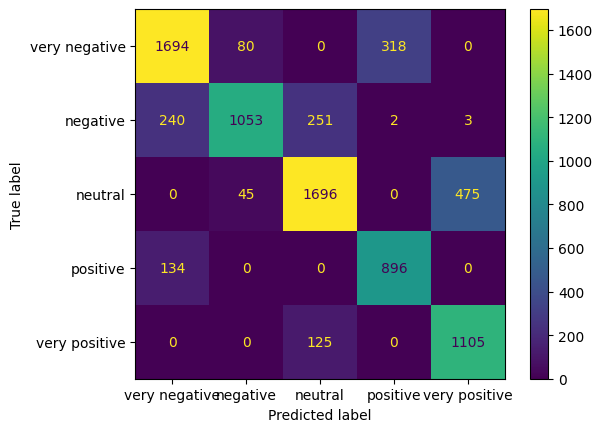

F1 score: 0.7935344774776065
Final mse on test set: (0.002957291732959796, 0.7935344774776065)


In [ ]:
# Initializing DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Initializing DistilBert model
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=1,
    output_attentions=False,
    output_hidden_states=False
)
config = model.config

# Modify the output layer to add a Sigmoid activation
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(config.dim, 1),
    torch.nn.Sigmoid()
)


#initalizaing optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

#creating encodings
encoded_train, encoded_test = create_encodings(trainset, testset, tokenizer)

input_ids_train = encoded_train['input_ids']
attn_masks_train = encoded_train['attention_mask']
labels_train = torch.tensor(trainset['sentiment values'].values)

input_ids_test = encoded_test['input_ids']
attn_masks_test = encoded_test['attention_mask']
labels_test = torch.tensor(testset['sentiment values'].values)

#creating data loaders
dataloader_train = create_dataloader(input_ids_train, attn_masks_train, labels_train)
dataloader_test = create_dataloader(input_ids_test, attn_masks_test, labels_test)

model.to(device)
model.eval()
test_mse, test_f1 = evaluate_model(model, dataloader_test)
print(f"Final mse on test set before tuning: {test_mse}")

#training the model
model, mse = tune_model(model, dataloader_train, optimizer)

print(f"Final mse on training set: {mse}")

#evaluating model
test_mse, test_f1 = evaluate_model(model, dataloader_test)
print(f"Final mse on test set: {test_mse}")


In [ ]:
# Save the model weights and configuration
model.save_pretrained("my_trained_model2")
# Delete the model and any other unnecessary variables
del model

# Clear GPU memory
torch.cuda.empty_cache()

In [ ]:
#model = BertForSequenceClassification.from_pretrained("my_trained_model2")
#model.to(device)
#evaluate_model(model, dataloader_test)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classi

Average test loss: 0.0636171679748345


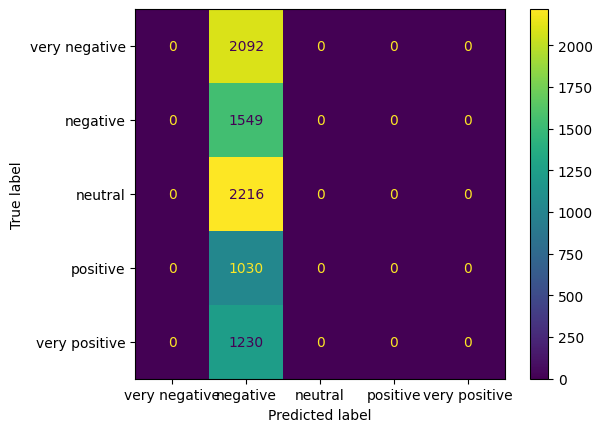

F1 score: 0.06116324157499895
Final mse on test set before tuning: 0.0636171679748345
Epoch 1/10
------------------------------


100%|██████████| 203/203 [02:09<00:00,  1.56it/s]


Average training loss: 0.028917943054048593
Epoch 2/10
------------------------------


100%|██████████| 203/203 [02:09<00:00,  1.56it/s]


Average training loss: 0.016056968899342813
Epoch 3/10
------------------------------


100%|██████████| 203/203 [02:09<00:00,  1.56it/s]


Average training loss: 0.011939842990264663
Epoch 4/10
------------------------------


100%|██████████| 203/203 [02:09<00:00,  1.56it/s]


Average training loss: 0.009987030041821558
Epoch 5/10
------------------------------


100%|██████████| 203/203 [02:09<00:00,  1.56it/s]


Average training loss: 0.008219059712707703
Epoch 6/10
------------------------------


100%|██████████| 203/203 [02:09<00:00,  1.56it/s]


Average training loss: 0.006930592129227196
Epoch 7/10
------------------------------


100%|██████████| 203/203 [02:09<00:00,  1.56it/s]


Average training loss: 0.005858174643337066
Epoch 8/10
------------------------------


100%|██████████| 203/203 [02:09<00:00,  1.56it/s]


Average training loss: 0.005139243028590024
Epoch 9/10
------------------------------


100%|██████████| 203/203 [02:09<00:00,  1.56it/s]


Average training loss: 0.0044044473316300235
Epoch 10/10
------------------------------


100%|██████████| 203/203 [02:09<00:00,  1.56it/s]


Average training loss: 0.003935496078510517
Final mse on training set: 0.003935496078510517


100%|██████████| 203/203 [00:41<00:00,  4.91it/s]


Average test loss: 0.00198015312348581


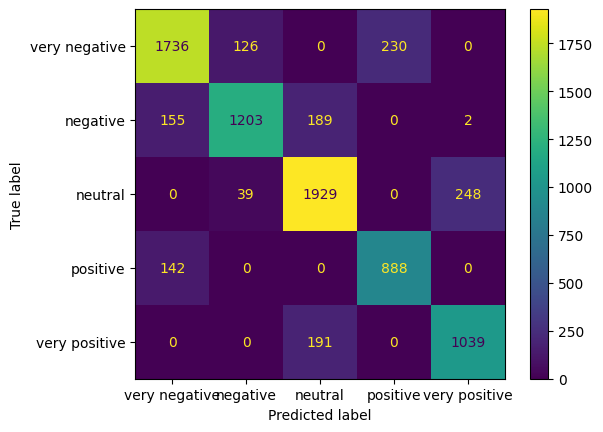

F1 score: 0.8370229380026398
Final mse on test set: (0.00198015312348581, 0.8370229380026398)


In [ ]:
# Initializing DeBERTa tokenizer
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

# Initializing DeBERTa model
config = DebertaConfig.from_pretrained('microsoft/deberta-base')
model = DebertaForSequenceClassification.from_pretrained(
    'microsoft/deberta-base',
    num_labels=1,
    output_attentions=False,
    output_hidden_states=False
)

config = model.config

# Modify the output layer to add a Sigmoid activation
#config = model.config
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(config.hidden_size, 1),
    torch.nn.Sigmoid()
)


#initalizaing optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

#creating encodings
encoded_train, encoded_test = create_encodings(trainset, testset, tokenizer)

input_ids_train = encoded_train['input_ids']
attn_masks_train = encoded_train['attention_mask']
labels_train = torch.tensor(trainset['sentiment values'].values)

input_ids_test = encoded_test['input_ids']
attn_masks_test = encoded_test['attention_mask']
labels_test = torch.tensor(testset['sentiment values'].values)

#creating data loaders
dataloader_train = create_dataloader(input_ids_train, attn_masks_train, labels_train)
dataloader_test = create_dataloader(input_ids_test, attn_masks_test, labels_test)

model.to(device)
model.eval()
test_mse, test_f1 = evaluate_model(model, dataloader_test)
print(f"Final mse on test set before tuning: {test_mse}")

#training the model
model, mse = tune_model(model, dataloader_train, optimizer)

print(f"Final mse on training set: {mse}")

#evaluating model
test_mse,test_f1 = evaluate_model(model, dataloader_test)
print(f"Final mse on test set: {test_mse}")


In [ ]:
# Save the model weights and configuration
model.save_pretrained("my_trained_model3")
# Delete the model and any other unnecessary variables
del model

# Clear GPU memory
torch.cuda.empty_cache()